In [1]:
import os
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

from IPython.display import Markdown as md
#from PIL import Image

In [2]:
tf.__version__

'2.1.0'

In [3]:
image_size = 256
labels = ['without_mask', 'with_mask']

def get_data(data_dir):
        
    images = []
    
# cria uma lista com o index de cada label com base no nome da raíz do diretório informado.
    for label in labels:
        dir = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
# percorre todas as imagens presentes no diretório, converte para grey_sacale e faz o resizing das imagens.
        for image in os.listdir(dir):    
            image_read = cv.imread(os.path.join(dir,image), cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read, (image_size, image_size))
            images.append([image_resized, class_num])

    return np.array(images)

load_full_dataset = get_data('../data/raw/validation_mask_images/')

In [4]:
mask_count = np.count_nonzero(load_full_dataset[:,1] == 1)
no_mask_count = np.count_nonzero(load_full_dataset[:,1] == 0)

print('Dataset original\n\n', len(load_full_dataset),
      'imagens no dataset com o tamanho', load_full_dataset[1,0].shape,
      '\n\nProporção',
      '\nSem máscara:\t', no_mask_count,
      '\nCom máscara:\t', mask_count)

Dataset original

 19 imagens no dataset com o tamanho (256, 256) 

Proporção 
Sem máscara:	 8 
Com máscara:	 11


In [5]:
x_features = []
y_labels = []

for feature, label in load_full_dataset:
    x_features.append(feature)
    y_labels.append(label)
    
del load_full_dataset

In [6]:
x_features = np.array(x_features).reshape(-1, image_size, image_size, 1)
y_labels = np.array(y_labels)
y_labels = np.expand_dims(y_labels, axis = 1)

x_test = x_features
y_test = y_labels

x_test  = x_test  / 255

print(x_test.shape)
print(y_test.shape)

(19, 256, 256, 1)
(19, 1)


In [7]:
model_NN = tf.keras.models.load_model('../models/model_NN.h5')
model_CNN = tf.keras.models.load_model('../models/model_CNN.h5')

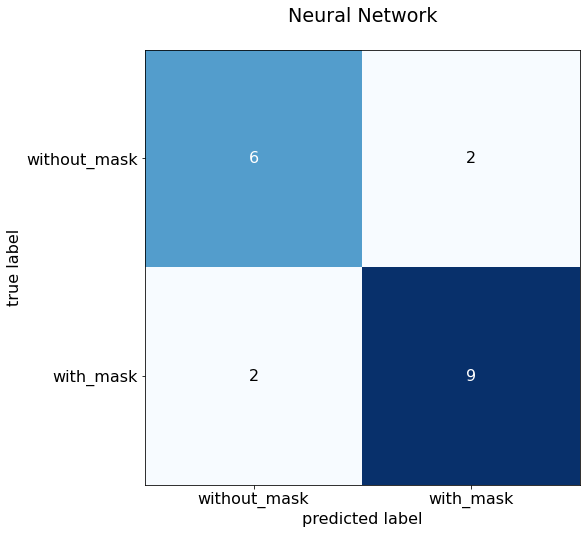

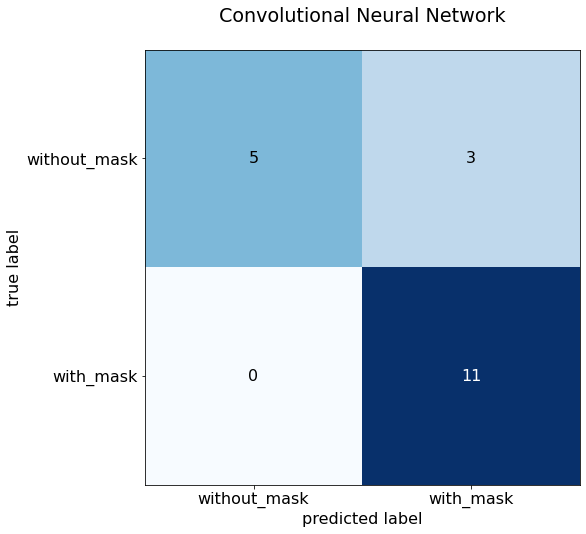

In [8]:
plt.rcParams.update({'font.size': 16})

def plot_confusion_mtx(model, x_test, plot_tittle):
    pred_prob = model.predict(x_test, batch_size = 8)
    pred = np.where(pred_prob > 0.5, 1,0)

    CM = confusion_matrix(y_test, pred)

    plot_confusion_matrix(conf_mat = CM, figsize = (16, 8))
    plt.title(plot_tittle)
    plt.xticks(range(2), labels)
    plt.yticks(range(2), labels)

    plt.show()

plot_confusion_mtx(model_NN, x_test, 'Neural Network')
plot_confusion_mtx(model_CNN, x_test, 'Convolutional Neural Network')

In [15]:
y_true = y_test
pred_prob = model_CNN.predict(x_test)
y_pred = np.where(pred_prob > 0.5, 1,0)

errors = y_pred != y_test
hits = y_pred == y_test

y_test_erros  = y_pred[errors[0:, 0]]
y_true_errors = y_true[errors[0:, 0]]
x_test_errors = x_test[errors[0:, 0]]

y_test_hits  = y_pred[hits[0:, 0]]
y_true_hits = y_true[hits[0:, 0]]
x_test_hits = x_test[hits[0:, 0]]

print('Neural Network')
print('quantidade de erros: \t' + str(len(y_test_erros)))
print('quantidade de hits: \t' + str(len(y_test_hits)))
print('Acuracia: \t' + str(len(y_test_hits) / (len(y_test_erros) + len(y_test_hits))))

Neural Network
quantidade de erros: 	3
quantidade de hits: 	16
Acuracia: 	0.8421052631578947


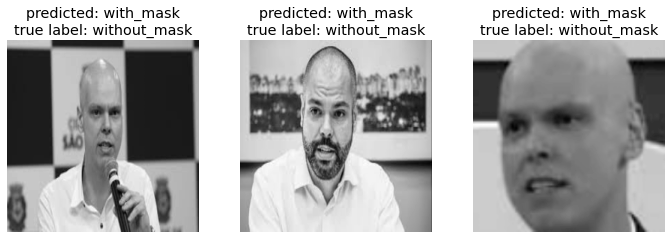

In [16]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize = (16, 12))
columns = 4
rows = 3

for i in range(1, columns * rows + 1):
    try:
        img = np.reshape(x_test_errors[i - 1], (256, 256))
        fig.add_subplot(rows, columns, i)
        plt.title('predicted: ' + str(labels[y_test_erros[i - 1][0]]) + 
                  '\ntrue label: ' + str(labels[y_true_errors[i - 1][0]]))
        plt.axis('off')
        plt.imshow(img, cmap = 'gray')
    except:
        break

plt.show()